In [1]:
import json
import numpy as np
from pyproj import Transformer
import pandas as pd
from shapely import wkt
from shapely.geometry import shape, Polygon, MultiPolygon, GeometryCollection, LineString, Point, box, mapping
from shapely.plotting import plot_polygon
from shapely.geometry.polygon import orient
from shapely.ops import unary_union
from tqdm import tqdm
import sys
import networkx as nx
import geopandas as gpd
from shapely.strtree import STRtree
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

def clean_geometry(geom):
    """
    Removes non-polygon geometries and polygons with zero area from a Shapely geometry.
    Returns a cleaned Polygon or MultiPolygon.
    """
    def extract_valid_polygons(g):
        if g.is_empty:
            return []
        elif isinstance(g, Polygon):
            return [g] if g.area > 0 else []
        elif isinstance(g, (MultiPolygon, GeometryCollection)):
            polygons = []
            for part in g.geoms:
                polygons.extend(extract_valid_polygons(part))
            return polygons
        else:
            return []  # Discard LineString, Point, etc.

    valid_polygons = extract_valid_polygons(geom)

    if not valid_polygons:
        return Polygon()  # Return empty polygon if nothing remains
    elif len(valid_polygons) == 1:
        return valid_polygons[0]
    else:
        return MultiPolygon(valid_polygons)

# The known minimum overlap (m) between Sentinel-2 tiles when they are in the same UTM zone
min_overlap = 9780

# Overlap detection threshold (m)
max_overlap = 200

# Maximum number of points in each polygon, in densification
max_points = 2000

# Approximate resolution (m), in densification
approx_resolution = 0.5

# Snap distance for eliminating small polygons when splitting at mean of UTM zone central meridians
lon_snap = 0  # 0.1 will get rid of one multipolygon

# Load GeoJSON
with open("3rdparty/sentinel-2-grid/grid.geojson") as f:
    geojson_data = json.load(f)

with open("3rdparty/sentinel-2-grid/grid_pretty.geojson", "w") as f:
    json.dump(geojson_data, f, indent=2)

# Tiles dictionary with the structure you want
tiles = {}
epsg_to_tiles = {}

to_wgs84 = {}
from_wgs84 = {}

def mean_angle(a1, a2):
    # Compute difference
    diff = a2 - a1

    # Wrap the difference to [-180, 180]
    while diff > 180:
        diff -= 360
    while diff < -180:
        diff += 360

    # Add half the (wrapped) difference to a1
    mid = a1 + diff / 2

    # Normalize result to [-180, 180]
    while mid > 180:
        mid -= 360
    while mid < -180:
        mid += 360

    return mid

def densify_and_project(polygon, from_wgs84, to_wgs84, threshold = approx_resolution):

    def distance(p1, p2):
        return np.hypot(p2[0]-p1[0], p2[1]-p1[1])

    # Extract coordinates from the polygon (excluding the closing point)
    coords = list(polygon.exterior.coords)
    i = 0
    while i < len(coords) - 1:
        utm_mid = ((coords[i][0] + coords[i+1][0])*0.5, (coords[i][1] + coords[i+1][1])*0.5)
        p0 = to_wgs84(*coords[i])
        p1 = to_wgs84(*coords[i+1])
        wgs84_mid = (mean_angle(p0[0], p1[0]), (p0[1] + p1[1])*0.5)
        wgs84_mid_in_utm = from_wgs84(*wgs84_mid)
        dist = distance(utm_mid, wgs84_mid_in_utm)
        if dist > threshold:
            coords.insert(i + 1, utm_mid)
            if len(coords) > max_points:
                print(list(polygon.exterior.coords))
                print([to_wgs84(x, y) for x, y in polygon.exterior.coords])
                #print(coords[i:i+3])
                raise ValueError("Too many points in polygon, consider lowering the threshold or increasing max_points")
        else:
            i += 1

    projected_coords = [to_wgs84(x, y) for x, y in coords]
    return Polygon(projected_coords)

print("Loading tile geometries and densifying to WGS84")
#for feature in tqdm(geojson_data.get("features", [])):
for feature in tqdm(filter(lambda a: a["properties"]["id"][:2] in ("30", "31", "32", "33", "34", "35", "36", "37", "38"), geojson_data.get("features", []))):
    sys.stdout.flush()
    props = feature.get("properties", {})
    feature_id = props.get("id") or props.get("name") or "unknown"

    # Extract EPSG code (string)
    epsg_code = props.get("epsg")

    # Create UTM <-> WGS84 transforms
    if epsg_code not in to_wgs84:
        try:
            epsg_int = int(epsg_code)
            to_wgs84[epsg_code] = Transformer.from_crs(f"EPSG:{epsg_int}", "EPSG:4326", always_xy=True).transform
            from_wgs84[epsg_code] = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_int}", always_xy=True).transform
        except ValueError:
            print(f"Invalid EPSG code: {epsg_code}")

    # Parse the UTM polygon from utmWkt if available
    utm_polygon = None
    utm_wkt = props.get("utmWkt")
    if utm_wkt:
        try:
            utm_geom = wkt.loads(utm_wkt)
            # Unwrap single-polygon multipolygons
            if utm_geom.geom_type == "MultiPolygon" and len(utm_geom.geoms) == 1:
                utm_geom = utm_geom.geoms[0]
            utm_polygon = utm_geom
        except Exception as e:
            print(f"Error parsing utmWkt for feature {feature_id}: {e}")

    # Crop utm polygons by half the known minimum overlap
    utm_polygon = utm_polygon.buffer(-min_overlap/2)
  
    # Store everything in tiles dict
    utm_zone = int(epsg_code[-2:])
    tile = {
        "id": feature_id,
        "utm_polygon": utm_polygon,
        "epsg_code": epsg_code,
        "utm_zone": utm_zone
    }

    tiles[feature_id] = tile
    if epsg_code not in epsg_to_tiles:
        epsg_to_tiles[epsg_code] = []
    epsg_to_tiles[epsg_code].append(tile)

Loading tile geometries and densifying to WGS84


8491it [00:01, 5069.50it/s]


In [2]:
print("Removing intersections within UTM zones")
utm_snap = {}
for epsg_code, epsg_tiles in epsg_to_tiles.items():
    utm_snap[epsg_code] = {
        "x": {},
        "y": {}
    }
    gdf = gpd.GeoDataFrame(epsg_tiles)
    gdf.set_index("id", inplace=True)
    gdf.set_geometry("utm_polygon", crs=None, inplace=True)
    pairs = gdf.sindex.query(gdf.geometry.values, predicate="intersects", output_format='indices').T
    
    for i, j in pairs:
        if i < j:
            tile1 = tiles[gdf.index[i]]
            tile2 = tiles[gdf.index[j]]
            poly1 = tile1["utm_polygon"]
            poly2 = tile2["utm_polygon"]
            
            # Split intersection horizontally
            intersection = poly1.intersection(poly2)
            bounds1 = poly1.bounds
            bounds2 = poly2.bounds
            if bounds1[0]+bounds1[2] > bounds2[0]+bounds2[2]:
                tile1, tile2 = tile2, tile1
                poly1, poly2 = poly2, poly1
                bounds1, bounds2 = bounds2, bounds1
            if bounds1[2]-bounds2[0] > 0 and bounds1[2]-bounds2[0] <= max_overlap:
                mid = (bounds1[2]+bounds2[0])*0.5
                utm_snap[epsg_code]["x"][bounds1[2]] = mid
                utm_snap[epsg_code]["x"][bounds2[0]] = mid

            # Split intersection vertically
            intersection = poly1.intersection(poly2)
            bounds = intersection.bounds
            if bounds1[1]+bounds1[3] > bounds2[1]+bounds2[3]:
                tile1, tile2 = tile2, tile1
                poly1, poly2 = poly2, poly1
                bounds1, bounds2 = bounds2, bounds1
            if bounds1[3]-bounds2[1] > 0 and bounds1[3]-bounds2[1] <= max_overlap:
                mid = (bounds1[3]+bounds2[1])*0.5
                utm_snap[epsg_code]["y"][bounds1[3]] = mid
                utm_snap[epsg_code]["y"][bounds2[1]] = mid

for tile in tiles.values():
    epsg_code = tile["epsg_code"]
    new_coords = []
    for coord in tile["utm_polygon"].exterior.coords:
        new_coords.append((
            utm_snap[epsg_code]["x"].get(coord[0], coord[0]),
            utm_snap[epsg_code]["y"].get(coord[1], coord[1])
        ))
    tile["utm_polygon"] = Polygon(new_coords)


Removing intersections within UTM zones


In [3]:
print("Densifying geometry in WGS84")
for tile in list(tiles.values()):
    epsg_code = tile["epsg_code"]
    tile["dense_wgs84_polygon"] = densify_and_project(tile["utm_polygon"], from_wgs84[epsg_code], to_wgs84[epsg_code])


Densifying geometry in WGS84


In [4]:
print("Finding intersecting tiles")
gdf = gpd.GeoDataFrame(tiles.values())
gdf.set_index("id", inplace=True)
gdf.set_geometry("dense_wgs84_polygon", crs="EPSG:4326", inplace=True)
pairs = gdf.sindex.query(gdf.geometry.values, predicate="intersects", output_format='indices').T
# Add pairs to graph
intersect_graph = nx.Graph()
for i, j in pairs:
    if i < j:
        intersect_graph.add_edge(gdf.index[i], gdf.index[j])

print(f"Average number of intersecting neighbors: {(len(pairs)-len(tiles))/len(tiles)}")

Finding intersecting tiles
Average number of intersecting neighbors: 7.691437993169238


In [5]:
display(tiles["31TGF"])
display(list(intersect_graph.neighbors("31TGF")))


{'id': '31TGF',
 'utm_polygon': <POLYGON ((704880 4595130, 804870 4595130, 804870 4495110, 704880 4495110, 7...>,
 'epsg_code': '32631',
 'utm_zone': 31,
 'dense_wgs84_polygon': <POLYGON ((5.454 41.482, 5.491 41.481, 5.529 41.48, 5.566 41.479, 5.604 41.4...>}

['31TFE', '31TFF', '31TFG', '31TGE', '32TKK', '32TKL', '31TGG', '32TKM']

In [6]:
# Optional!
if False:
    print("Finding redundant tiles")
    for tile_id1, tile1 in list(tiles.items()):
        poly1 = tile1["dense_wgs84_polygon"]
        bounds1 = poly1.bounds
        minx1, miny1, maxx1, maxy1 = bounds1
        tile_ids2 = filter(lambda tile_id2: tiles[tile_id2]["epsg_code"] != tile1["epsg_code"], intersect_graph.neighbors(tile_id1) if tile_id1 in intersect_graph else [])
        polys2 = list(map(lambda tile_id2: tiles[tile_id2]["dense_wgs84_polygon"], tile_ids2))
        if len(polys2) > 0:
            poly2 = unary_union(polys2)
            if tile_id1 == "32WNE":
                # Create figure and axis
                fig, ax = plt.subplots()

                # Plot poly1
                x1, y1 = poly1.exterior.xy
                ax.plot(x1, y1, color='blue', label='Polygon 1')

                # Plot poly2
                x2, y2 = poly2.exterior.xy
                ax.plot(x2, y2, color='red', label='Polygon 2')

                # Set equal aspect ratio
                ax.set_aspect('equal')

                # Add legend and grid
                ax.legend()
                ax.grid(True)

                # Show plot
                plt.show()            
            residual_poly1 = clean_geometry(poly1.difference(poly2))
            if residual_poly1.is_empty:
                print(f"Removing {tile_id1}")
                #del tiles[tile_id1]
                #intersect_graph.remove_node(tile_id1)


In [7]:
# Split intersections across UTM zones by splitting at the mean of the central meridian of the UTM zones.
for tile_id1, tile1 in tiles.items():
    poly1 = tile1["dense_wgs84_polygon"]
    meridian1 = -180 + (tile1["utm_zone"]-1)*6 + 3
    tile_ids2 = list(filter(lambda tile_id2: tiles[tile_id2]["utm_zone"] != tile1["utm_zone"], intersect_graph.neighbors(tile_id1)))
    poly1_cutters = []
    for tile_id2 in tile_ids2:
        tile2 = tiles[tile_id2]
        poly2 = tile2["dense_wgs84_polygon"]
        intersection = poly1.intersection(poly2)
        if intersection.area > 0:
            meridian2 = -180 + (tile2["utm_zone"]-1)*6 + 3
            mean_meridian = (meridian1 + meridian2)*0.5
            left_bbox = box(-180, -90, mean_meridian, 90)
            right_bbox = box(mean_meridian, -90, 180, 90)
            if meridian1 < meridian2:
                poly2_new = poly2.intersection(right_bbox)
            else:
                poly2_new = poly2.intersection(left_bbox)
            poly1_cutters.append(poly2_new)
    poly1_cutter = unary_union(poly1_cutters)
    poly1 = poly1.difference(poly1_cutter)
    tile1["clipped_dense_wgs84_polygon"] = poly1


1.52281751520641


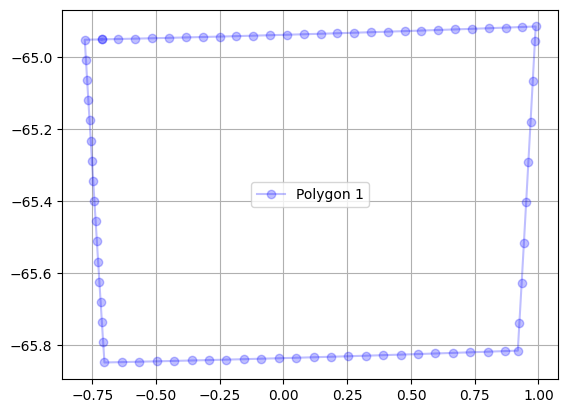

In [8]:
poly1 = tiles["30DXN"]["clipped_dense_wgs84_polygon"]

# Create figure and axis
fig, ax = plt.subplots()

if type(poly1) == Polygon:
    geoms = [poly1]
else:
    geoms = poly1.geoms
for poly in geoms:
    # Plot poly1
    x1, y1 = poly.exterior.coords.xy
    ax.plot(x1, y1, color='blue', label='Polygon 1', marker="o", alpha=0.25)
    print(poly.area)

# Set equal aspect ratio
#ax.set_aspect('equal')

# Add legend and grid
ax.legend()
ax.grid(True)

#ax.set_xlim(-2.9, -2.89)
#ax.set_ylim(-64.955, -64.953)

# Show plot
plt.show()        

In [9]:
if False:
    print("Joining points that are very close together")

    gdf = gpd.GeoDataFrame(columns=["geometry"], geometry=[], crs="EPSG:4326")

    for tile in tqdm(tiles.values()):
        geom = tile["dense_wgs84_polygon"]
        new_geoms = []

        # Handle different geometry types
        if isinstance(geom, MultiPolygon):
            geoms = geom.geoms
        elif isinstance(geom, Polygon):
            geoms = [geom]
        else:
            continue  # skip invalid geometry

        for poly in geoms:
            old_coords = poly.exterior.coords
            new_coords = []

            for x, y in old_coords:
                pt = Point(x, y)
                point_utm = from_wgs84[tile["epsg_code"]](x, y)
                pt_snap = Polygon([to_wgs84[tile["epsg_code"]](x, y) for x, y in Point(point_utm).buffer(1.0e-7).exterior.coords])
                matches = gdf.sindex.query(pt_snap, predicate="intersects")
                if len(matches) > 0:
                    min_dist = float("inf")
                    nearest_point = None
                    for gdf_point in [gdf.geometry[i] for i in matches]:
                        gdf_point_utm = from_wgs84[tile["epsg_code"]](gdf_point.x, gdf_point.y)
                        dist = np.hypot(gdf_point_utm[0]-point_utm[0], gdf_point_utm[1]-point_utm[1])
                        if dist < min_dist:
                            min_dist = dist
                            nearest_point = gdf_point
                        None
                    if min_dist > 0:
                        print(f"{min_dist}")
                    new_coords.append((nearest_point.x, nearest_point.y))
                else:
                    new_row = gpd.GeoDataFrame({"geometry": [pt]}, crs=gdf.crs)
                    gdf = pd.concat([gdf, new_row], ignore_index=True)
                    new_coords.append((x, y))

            cleaned_poly = Polygon(new_coords)
            new_geoms.append(cleaned_poly)
        if len(new_geoms) > 1:
            None
            #tile["dense_wgs84_polygon"] = MultiPolygon(new_geoms)
        else:
            None
            #tile["dense_wgs84_polygon"] = new_geoms[0]

Looking for remaining significant overlaps
Showing area 9.610586093138426e-18 between 30CWN and 31CEJ


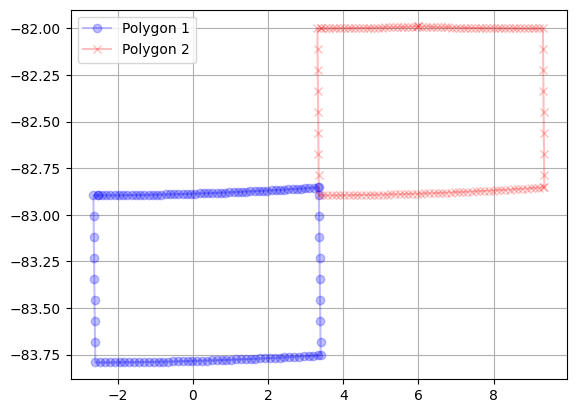

Showing area 1.524997317376216e-17 between 30CWP and 31CEJ


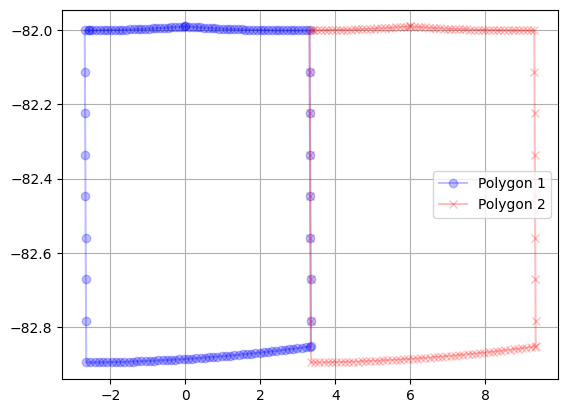

Showing area 2.8091350904408303e-18 between 30DXF and 31DDB


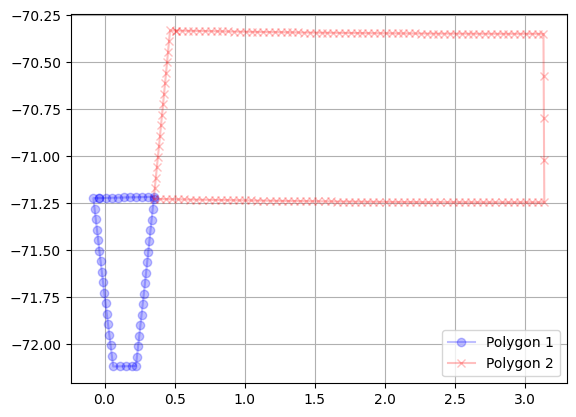

Showing area 1.1172761258476545e-17 between 30DXG and 31DDB


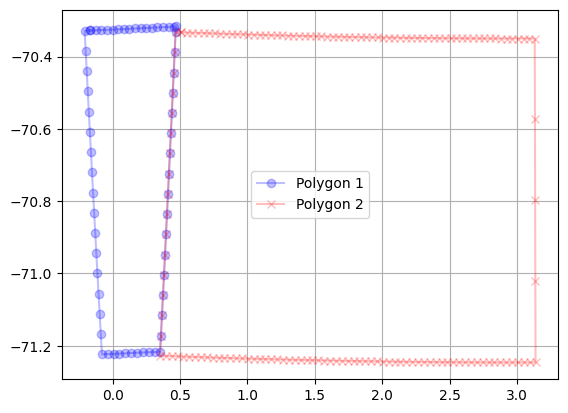

Showing area 2.593247524248515e-18 between 30DXG and 31DDC


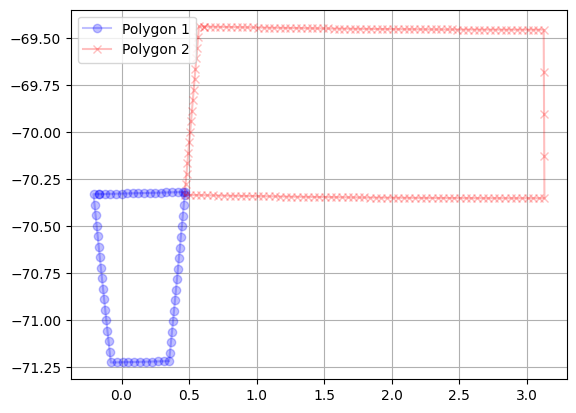

Showing area 6.7325817132634394e-18 between 30DXH and 31DDC


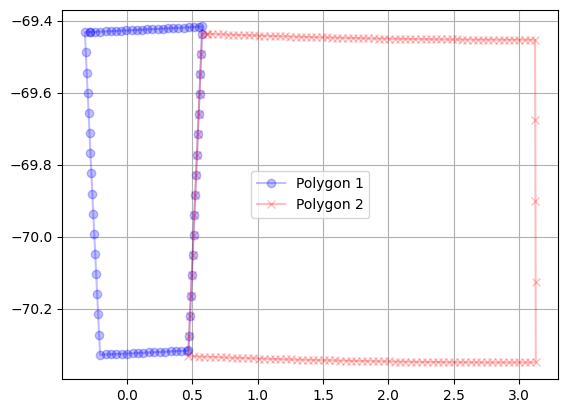

Showing area 8.903830221559382e-18 between 30DXL and 31DDG


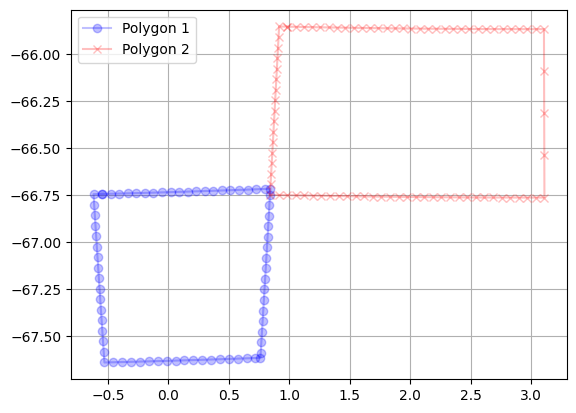

Showing area 6.645381595806706e-18 between 30DXM and 31DDG


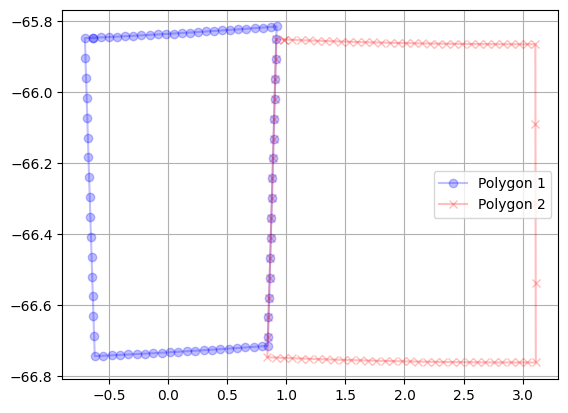

Showing area 4.26253276703145e-17 between 30DXP and 31ECK


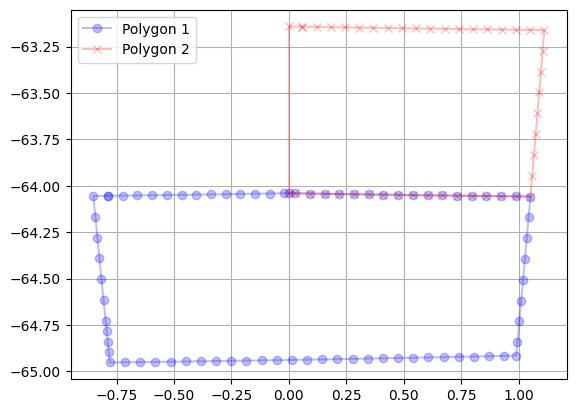

Showing area 1.6253604881612443e-20 between 30EXQ and 31ECK (too many plots, stopping after this)


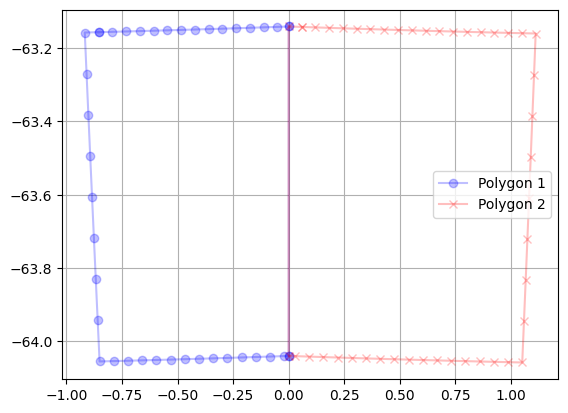

Total num nonzero areas: 133 (max area 1.8202790276643728e-16)


In [10]:
# Verify that we have no more overlaps
print("Looking for remaining significant overlaps")
plot_count = 10
num_nonzero = 0
max_area = 0
max_area_tile_id1 = None
max_area_tile_id2 = None
for tile_id1, tile1 in tiles.items():
    poly1 = tile1["clipped_dense_wgs84_polygon"]
    meridian1 = -180 + (tile1["utm_zone"]-1)*6 + 3
    tile_ids2 = filter(lambda tile_id2: tile_id1 < tile_id2, intersect_graph.neighbors(tile_id1))
    for tile_id2 in tile_ids2:
        tile2 = tiles[tile_id2]
        poly2 = tile2["clipped_dense_wgs84_polygon"]
        area = poly1.intersection(poly2).area
        if area > 0:
            if type(poly1) == Polygon and type(poly2) == Polygon:
                if plot_count > 0:
                    print(f"Showing area {area} between {tile_id1} and {tile_id2}{"" if plot_count > 1 else " (too many plots, stopping after this)"}")

                    # Create figure and axis
                    fig, ax = plt.subplots()

                    # Plot poly1
                    x1, y1 = poly1.exterior.coords.xy
                    ax.plot(x1, y1, color='blue', label='Polygon 1', marker="o", alpha=0.25)

                    # Plot poly2
                    x2, y2 = poly2.exterior.coords.xy
                    ax.plot(x2, y2, color='red', label='Polygon 2', marker="x", alpha=0.25)

                    # Set equal aspect ratio
                    #ax.set_aspect('equal')

                    # Add legend and grid
                    ax.legend()
                    ax.grid(True)

                    #ax.set_xlim(-2.9, -2.89)
                    #ax.set_ylim(-64.955, -64.953)

                    # Show plot
                    plt.show()                
                    plot_count -= 1
                if area > 1.0e-6:
                    print(f"Too large area {area} between {tile_id1} and {tile_id2}")
                if area > max_area:
                    max_area = area
                    max_area_tile_id1 = tile_id1
                    max_area_tile_id2 = tile_id2
                num_nonzero += 1
print(f"Total num nonzero areas: {num_nonzero} (max area {max_area})")


Showing geometries 35FQD and 36FUJ with maximum intersection area 1.8202790276643728e-16
(Note: endpoints are plotted twice)


[(29.93679204375239, -50.558690798347406),
 (29.98084600793863, -50.55757060647014),
 (30.024897154601568, -50.55643376985837),
 (30.06894544242956, -50.555280291061614),
 (30.11299083012795, -50.554110172666405),
 (30.157033276419302, -50.5529234172963),
 (30.20107274004367, -50.55172002761179),
 (30.245109179758817, -50.55050000631038),
 (30.245771008884738, -50.55048141924731),
 (30.24503491979298, -50.56313738279529),
 (30.23846118852028, -50.675443092211104),
 (30.231845395184315, -50.78774600292191),
 (30.22518718662389, -50.90004611125308),
 (30.218486205590033, -51.01234341350104),
 (30.211742090687324, -51.124637905932325),
 (30.204954476314285, -51.23692958478268),
 (30.19812299260262, -51.349218446256),
 (30.19184818193171, -51.45169104563975),
 (30.173741835621993, -51.45218511860327),
 (30.128840300135753, -51.453393100258594),
 (30.08393566239745, -51.45458390580766),
 (30.03902796655942, -51.45575753249771),
 (29.994117256793054, -51.45691397761536),
 (29.949203577288497

[(30.28910267919894, -50.56417220324366),
 (30.333173002667063, -50.5651903641466),
 (30.377245848771654, -50.56619186321894),
 (30.421321176072, -50.56717669821265),
 (30.465398943112618, -50.56814486691692),
 (30.509479108423513, -50.56909636715809),
 (30.553561630520377, -50.57003119679974),
 (30.5976464679049, -50.57094935374268),
 (30.64173357906495, -50.57185083592492),
 (30.685822922474866, -50.5727356413218),
 (30.72991445659568, -50.57360376794589),
 (30.774008139875352, -50.57445521384702),
 (30.818103930749057, -50.57528997711238),
 (30.862201787639382, -50.576108055866435),
 (30.906301668956612, -50.576909448271),
 (30.95040353309894, -50.57769415252524),
 (30.994507338452742, -50.578462166865656),
 (31.038613043392818, -50.579213489566115),
 (31.082720606282624, -50.5799481189379),
 (31.12682998547454, -50.58066605332966),
 (31.170941139310088, -50.581367291127464),
 (31.21505402612023, -50.58205183075479),
 (31.259168604225547, -50.582719670672546),
 (31.303284831936537, 

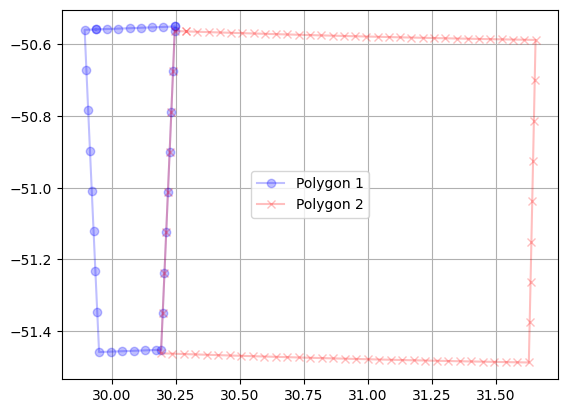

In [11]:
print(f"Showing geometries {max_area_tile_id1} and {max_area_tile_id2} with maximum intersection area {max_area}")
print("(Note: endpoints are plotted twice)")
id1 = max_area_tile_id1
id2 = max_area_tile_id2
display(list(tiles[id1]["clipped_dense_wgs84_polygon"].exterior.coords))
display(list(tiles[id2]["clipped_dense_wgs84_polygon"].exterior.coords))

poly1 = tiles[id1]["clipped_dense_wgs84_polygon"]
poly2 = tiles[id2]["clipped_dense_wgs84_polygon"]

# Create figure and axis
fig, ax = plt.subplots()

# Plot poly1
x1, y1 = poly1.exterior.coords.xy
ax.plot(x1, y1, color='blue', label='Polygon 1', marker="o", alpha=0.25)

# Plot poly2
x2, y2 = poly2.exterior.coords.xy
ax.plot(x2, y2, color='red', label='Polygon 2', marker="x", alpha=0.25)

# Set equal aspect ratio
#ax.set_aspect('equal')

# Add legend and grid
ax.legend()
ax.grid(True)

#ax.set_xlim(-2.9, -2.89)
#ax.set_ylim(-64.955, -64.953)

# Show plot
plt.show()    

In [12]:
# Optional!
if False:
    print("Donating residual intersections to alphabetically earlier/later tiles")
    donate_to_earlier = True
    while True:
        num_donated = 0
        for tile_id1, tile1 in tiles.items():
            poly1 = tile1["clipped_dense_wgs84_polygon"]
            tile_ids2 = list(filter(lambda tile_id2: tile_id1 < tile_id2, intersect_graph.neighbors(tile_id1)))
            for tile_id2 in tile_ids2:
                tile2 = tiles[tile_id2]
                poly2 = tile2["clipped_dense_wgs84_polygon"]
                intersection = poly1.intersection(poly2)
                if intersection.area > 0:
                    print(intersection.area)
                    # Donate intersection to poly1
                    if donate_to_earlier:
                        poly2 = clean_geometry(poly2.difference(poly1))
                        tile2["clipped_dense_wgs84_polygon"] = poly2
                    else:
                        poly1 = clean_geometry(poly1.difference(poly2))
                        tile1["clipped_dense_wgs84_polygon"] = poly1
                    donate_to_earlier = not donate_to_earlier    
                    num_donated += 1
        print(f"Donated {num_donated} intersections")
        if num_donated == 0:
            break

In [13]:
# Save clipped polygons
output_geojson = {
    "type": "FeatureCollection",
    "features": []
}
for tile in tiles.values():
    # Project utm polygon to WGS84 without densification
    geom = tile["clipped_dense_wgs84_polygon"]
    if type(geom) == Polygon:
        geoms = [geom]
    elif type(geom) == MultiPolygon:
        geoms = geom.geoms
    else:
        continue
    for index, geom in enumerate(geoms):
        utm_coords = []
        for x, y in geom.exterior.coords:
            new_x, new_y = from_wgs84[tile["epsg_code"]](x, y)
            utm_coords.append((new_x, new_y))
        feature = {
            "type": "Feature",
            "properties": {
                "id": tile["id"] if len(geoms) == 1 else f"{tile["id"]}_{index}",
                "tile_id": tile["id"],
                "epsg": tile["epsg_code"],
                "area": Polygon(utm_coords).area
            },
            "geometry": mapping(geom)
        }
        output_geojson["features"].append(feature)
with open("preferred_tiles.geojson", "w") as f:
    json.dump(output_geojson, f, indent=2)